**Πριν ξεκινήσεις να τρέχεις τον κώδικα**

Κάνε κλικ στο <kbd>Runtime</kbd> στην κορυφή της σελίδας, και στις επιλογές <kbd>change runtime type</kbd> ή <kbd>runtime options</kbd>. Εκεί επίλεξε ένα κουτάκι που λέει <kbd>(T4) GPU</kbd>.

**Πώς χρησιμοποιείς αυτό το αρχείο;**

Αυτό το αρχείο είναι ένα *jupyter notebook*, που αποτελείται από κελιά κειμένου (όπως αυτό) και κελιά κώδικα (όπως το παραπάνω). Μπορείς να τρέξεις τα κελιά κώδικα με <kbd>shift</kbd> + <kbd>enter</kbd>. Πριν προχωρήσεις, είναι σημαντικό να τρέξεις το παραπάνω κελί, ώστε o υπολογιστής να μπορεί να εισάγει όλες τις απαραίτητες συναρτήσεις.


In [1]:
#Ενότητα 1: Εισαγωγή απραίτητων εργαλείων

import pip

import numpy as np
import os
from glob import glob
import torch
from PIL import Image
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F

%pip install medmnist

%pip install SimpleITK
import SimpleITK as sitk


!git clone https://github.com/NicosStarreveld/WorkshopCNNs.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 20.5 MB/s eta 0:00:00
Cloning into 'WorkshopCNNs'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 238 (delta 99), reused 115 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (238/238), 34.10 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (99/99), done.


# Τα μαθηματικά πίσω από την ΤΝ - Εφαρμογή: ιατρικά δεδομένα

Τα νευρωνικά δίκτυα (CNNs) μπορούν να χρησιμοποιηθούν για την αυτόματη ερμηνεία εικόνων. Οι υπολογιστές είναι μάλιστα καλύτεροι σε ορισμένες εργασίες ανάλυσης εικόνας από τους ανθρώπους, επειδή οι άνθρωποι έχουν μικρή διάρκεια συγκέντρωσης. Σ' αυτό το εργαστήριο θα ρίξουμε μια ματιά στο πώς ένας υπολογιστής μπορεί να ερμηνεύει εικόνες. Θα εργαστούμε με ένα (δημόσιο) ιατρικό σύνολο δεδομένων και θα εκπαιδεύσουμε το δικό μας δίκτυο που μπορεί να ξεχωρίζει μεταξύ εικόνων δοντιών με και χωρίς απονεύρωση.

### Ψηφιακές εικόνες

Ο υπολογιστής βλέπει μια εικόνα ως έναν μεγάλη πίνακα με αριθμούς, κάθε στοιχείο του πίνακα (γνωστότερο ως *pixel*) περιέχει την τοπική ένταση της εικόνας. Στην περίπτωση μιας έγχρωμης εικόνας, πρόκειται για τρεις πίνακες τον έναν πάνω στον άλλο, που αντιπροσωπεύουν αντίστοιχα το κόκκινο, το μπλε και το πράσινο κανάλι. Στην περίπτωση μιας ασπρόμαυρης εικόνας, η ψηφιακή εικόνα είναι ένας μοναδικός πίνακας με εντάσεις.

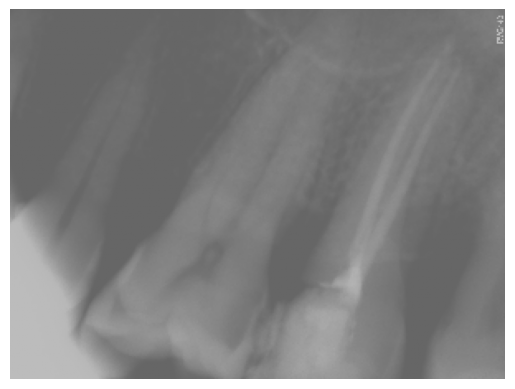

In [2]:
#Ενότητα 2: προβολή εικόνων

def open_img(path):
    if path.endswith('.png'):
        return np.array(Image.open(path).convert('L'))
    elif path.endswith('.mhd'):
        return sitk.GetArrayFromImage(sitk.ReadImage(path))[32,:,:] # return 1 slice of the image

def visualize(img, clim=[-300,450]):
    plt.imshow(img, cmap='gray', clim=clim)
    plt.axis('off')
    plt.show()

"""
Για να διαβάσει σωστά τις εικόνες πρέπει να δώσουμε τη διεύθυνση στην οποία
είναι καταχωρημένες. Οι φωτογραφίες είναι σε δύο φακέλους Xrays_with & Xrays_without
"""

img_path = 'WorkshopCNNs/Xrays_with/167.png'
img = open_img(img_path)
# visualiseer beeld
visualize(img)

### Convolutions

Ένας υπολογιστής μπορεί να κατανοήσει μια εικόνα μέσω των λεγόμενων convolutions (συνέληξεις). Ένα convolution αποτελείται πάντα από έναν *πυρήνα* (kernel), έναν μικρό πίνακα που περιέχει ένα χαρακτηριστικό μοτίβο, το οποίο πολλαπλασιάζεται τοπικά με τις εντάσεις της εικόνας. Στην παρακάτω κινούμενη εικόνα, το ανώτερο πράσινο επίπεδο είναι ο πυρήνας, και το μπλε επίπεδο είναι η εικόνα που πρέπει να ερμηνευτεί, η μετακίνηση του πυρήνα ονομάζεται convolution. Το αποτέλεσμα ενός convolution είναι ακόμα ένας *πίνακας*, ο οποίος έχει παρόμοιες διαστάσεις με την αρχική εικόνα.

![](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630)

 Με μια συνελικτική λειτουργία στην ουσία συγκρίνεται η ένταση κάθε pixel με αυτή των γειτόνων του, ανάλογα με το μοτίβο στον πυρήνα. Επιλέγοντας έξυπνα το μοτίβο στον πυρήνα, μπορούν να αναγνωριστούν ορισμένα χαρακτηριστικά στην εικόνα, για παράδειγμα οι κάθετες άκρες. Αποτελεσματικά, για κάθε pixel εξετάζεται πώς το περιβάλλον του ταιριάζει με το μοτίβο στον πυρήνα. Επιπλέον, μια συνελικτική λειτουργία μπορεί να χρησιμοποιηθεί για τη μείωση του θορύβου σε μια εικόνα, κάτι που ονομάζεται *smoothing*.

Παρακάτω παρουσιάζουμε μερικά παραδείγματα συνελικτικών πυρήνων/ Αυτά τα παραδείγματα δεν έχουν σχέση με την εφαρμογή που θέλουμε, τα δίνω απλά για να δείξω τι κάνει ένας πυρήνας όταν εφαρμοστεί πάνω σε μια εικόνα.

In [3]:
# Ενότητα 3: Μια συνάρτηση η οποία εφαρμόζει έναν πυρήνα kernel πάνω σε μια εικόνα image.

def apply_conv(image, kernel, iter=1):
    image, kernel = torch.from_numpy(image).float(), torch.from_numpy(kernel).float()
    img_shape, kernel_shape = image.shape, kernel.shape
    fig, ax = plt.subplots(1,1)
    for level in range(iter):
        image = F.conv2d(image.reshape(1,1, img_shape[0], img_shape[1]),
                         kernel.reshape(1,1, kernel_shape[0], kernel_shape[1]),
                         padding='same').squeeze()
        ax.imshow(image.numpy(), cmap='gray', clim=[-300,450])
        ax.set_title(f'Applied convolution {level+1} times')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)
        plt.close()

In [ ]:
# convolutiοn 1: move image to the left
# define kernel:
kernel = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 0, 0]])
# how often we apply the kernel
n_iters = 20

apply_conv(img, kernel, n_iters)

In [ ]:
# convolution 2: smoothing





kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]]) * 1/16

n_iters = 20

apply_conv(img, kernel, n_iters)

In [ ]:
# convolution 3: detecting vertical lines
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

n_iters = 1

apply_conv(img, kernel, n_iters)


## Convolutional Neural Network

Οι εν λόγω συνελικτικές λειτουργίες αποτελούν τη βάση ενός λεγόμενου συνελικτικού νευρωνικού δικτύου. Στην ουσία, πρόκειται για ένα νευρωνικό δίκτυο που μπορεί να χρησιμοποιηθεί για διάφορες εργασίες υπολογιστικής όρασης, όπως η ταξινόμηση εικόνων, η ανίχνευση αντικειμένων ή ακόμη και ο προσδιορισμός των ακριβών ορίων ενός αντικειμένου σε μια εικόνα. Τα συνελικτικά νευρωνικά δίκτυα αποτελούνται από μια στοίβα συνελικτικών επιπέδων. Εφαρμόζοντας συνεχώς συνελικτικές λειτουργίες μέσα σε μια «στοίβα», ο υπολογιστής μπορεί να εξετάζει μια ολοένα και μεγαλύτερη τοπική περιοχή γύρω από κάθε εικονοστοιχείο (perceptive field). Οι πυρήνες σε όλες αυτές τις συνελικές λειτουργίες δεν καθορίζονται από ανθρώπους, αλλά προσδιορίζονται κατά τη διάρκεια της εκπαίδευσης αυτού του δικτύου. Στην υπόλοιπη ενότητα αυτού του notebook θα δείξουμε ένα μικρό παράδειγμα του πώς λειτουργεί αυτό και πώς μπορούμε να αξιολογήσουμε πόσο καλό είναι το δίκτυο στη συγκεκριμένη εργασία του.

## Σωστή βάση δεδομένων σύμφωνα με τις οδηγίες του ΜedMNist

In [81]:
# Ενότητα 4: Φτιάχνω τις εικόνες που έφτιαξες σε μορφή ώστε να τις διαβάσει το CNN

import cv2
from sklearn.model_selection import train_test_split

images = []
labels = []
originals = []

for filename in os.listdir("WorkshopCNNs/Xrays_with"):
  if 'ipynb' in filename: continue
  orig_img = cv2.imread(f"WorkshopCNNs/Xrays_with/{filename}", cv2.IMREAD_GRAYSCALE)
  orig_img = cv2.resize(orig_img, (224, 224))
  img = cv2.resize(orig_img, (28, 28))
  img = img.astype(np.uint8)
  images.append(img)
  labels.append([1])
  originals.append(orig_img)

for filename in os.listdir("WorkshopCNNs/Xrays_without"):
  if 'ipynb' in filename: continue
  orig_img = cv2.imread(f"WorkshopCNNs/Xrays_without/{filename}", cv2.IMREAD_GRAYSCALE)
  orig_img = cv2.resize(orig_img, (224, 224))
  img = cv2.resize(orig_img, (28, 28))
  img = img.astype(np.uint8)
  images.append(img)
  labels.append([0])
  originals.append(orig_img)

images = np.array(images)
labels = np.array(labels)
originals = np.stack(originals, axis=0)

In [82]:
# Train/val/test splits
X_train, X_temp, X_train_orig, X_temp_orig, y_train, y_temp = train_test_split(images, originals, labels, test_size=0.3)
X_val, X_test, X_val_orig, X_test_orig, y_val, y_test = train_test_split(X_temp, X_temp_orig, y_temp, test_size=0.5)

In [83]:
# Opslaan in MedMNIST-formaat
np.savez("teethmnist.npz",
         train_images=X_train, train_labels=y_train, train_orig=X_train_orig,
         val_images=X_val, val_labels=y_val, val_orig = X_val_orig,
         test_images=X_test, test_labels=y_test, test_orig = X_test_orig)

Στον κώδικα εδώ κάτω φτιάχνω μια βάση δεδομένων (κλάση) TeethMNIST με τα σωστά labels. Το CNN θα χρησιμοποιήσει αυτήν την κλάση.

In [84]:
#Ενότητα 5: Κλάση TeethMNIST

from torch.utils.data import Dataset

class TeethMNIST(Dataset):
  def __init__(self, split="train", transform=None):
      data = np.load("teethmnist.npz", allow_pickle=True)

      self.images = data[f"{split}_images"]
      self.labels = data[f"{split}_labels"]
      self.orig = data[f"{split}_orig"]

      self.transform = transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img = self.images[idx].astype(np.float32)
      label = int(self.labels[idx])
      orig = self.orig[idx]

      # Add channel dimension: (1, H, W)
      img = np.expand_dims(img, axis=0)

      if self.transform:
          img = self.transform(img)

      return {"img": img, "label": label, "orig": orig}

In [85]:
# A function to visualize the scans
def visualize_sample(sample):
    plt.imshow(sample['img'], 'gray')
    if sample['label'] == 1:
        plt.title('Patient with inflamation')
    else:
        plt.title('Healthy patient')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [24]:
import medmnist
%pip install monai

In [86]:
from monai.transforms import NormalizeIntensity

data_transform = NormalizeIntensity(subtrahend=.5, divisor=.5)

train_dataset = TeethMNIST(split="train", transform=data_transform)
val_dataset = TeethMNIST(split="val", transform=data_transform)
test_dataset = TeethMNIST(split="test", transform=data_transform)

## Πειραματισμός με τον κώδικα και εξερεύνηση του dataset):

Το train_dataset είναι ένα σύνολο από 4708 σαρώσεις, όπου κάθε σάρωση έχει μια ετικέτα (label), η οποία μπορεί να είναι 0 ή 1.
Η ετικέτα 0 σημαίνει ότι ο ασθενής είναι υγιής, ενώ η ετικέτα 1 σημαίνει ότι ο ασθενής έχει πνευμονία.

Αν πληκτρολογήσεις
<kbd>visualize(train_dataset[k]['img'])</kbd>
μπορείς να δεις την k‑οστή εικόνα.

Αν πληκτρολογήσεις
<kbd>print(train_dataset[k]['label'])</kbd>
θα δεις την ετικέτα που αντιστοιχεί σε αυτή την εικόνα.

Πειραματίσου με
<kbd>visualize_sample(train_dataset[k])</kbd>
για να εξερευνήσεις το dataset.

/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


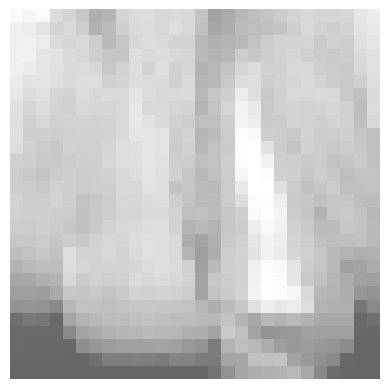

In [87]:
sample = train_dataset[11]
visualize(sample["img"][0])

Παρακάτω μπορείς να εμφανίσεις μια ακτινογραφία ενός τυχαίου ασθενούς. Για να μπορέσουμε αργότερα να ερμηνεύσουμε καλύτερα τις προβλέψεις του αλγορίθμου, είναι σημαντικό να γνωρίζουμε πόσες εικόνες στα δεδομένα προέρχονται από ασθενείς με απονευρώσεις και πόσες από ασθενείς χωρίς.

Παρακάτω μπορείς να δεις πόσα δεδομένα ανήκουν στη μία και πόσα στην άλλη κατηγορία.

**Ερώτηση**: Είναι το dataset ισορροπημένο; Ποιο ποσοστό των δεδομένων εκπαίδευσης αφορά ασθενείς με απονεύρωση;

/tmp/ipython-input-1516082767.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


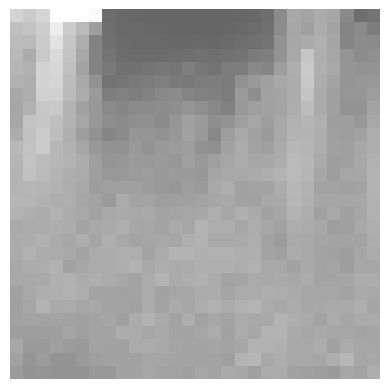

TypeError: 'int' object is not subscriptable

In [11]:
# visualize a random sample
index = np.random.choice(np.arange(len(train_dataset)))
sample = train_dataset[index]
visualize(sample["img"][0])

#Question: is this dataset inbalanced?
counts = {0: 0, 1:0}
for sample in train_dataset:
    counts[sample['label'][0]] += 1
print('Aanal label 0:', counts[0], 'Aantal label 1:', counts[1])

Τώρα θα δημιουργήσουμε το πραγματικό δίκτυο. Χωρίζουμε τα δεδομένα σε ένα σύνολο δοκιμής και ένα σύνολο επικύρωσης, ώστε αργότερα να μπορούμε να ελέγξουμε αν το μοντέλο υπερπροσαρμόζεται. Δημιουργούμε ένα μοντέλο με δύο στρώματα συνελικτικών φίλτρων με kernels 3x3. Πίσω από αυτά ακολουθεί ένα νευρωνικό δίκτυο και φροντίζουμε να υπάρχει μία μόνο έξοδος (απονεύρωση ή όχι). Αυτό το μοντέλο έχει υλοποιηθεί ως Net().

In [88]:
import monai
from monai.data import DataLoader, pad_list_data_collate

"""
Δημιουργούμε το σύνολο επικύρωσης, ώστε να μπορούμε να δούμε πώς γενικεύει
το μοντέλο κατά την εκπαίδευση. Το σύνολο επικύρωσης δεν χρησιμοποιείται
για την προσαρμογή των βαρών του μοντέλου.
"""

val_dataset = TeethMNIST(split="val", transform=data_transform)

# Training dataloader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataloader

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) # <-- same fix here


In [89]:
# Ενότητα 6: Κατασκευή δομής νευρωνικού δικτύου.

"""
Εδώ ορίζεται το πραγματικό μοντέλο. Αυτό το μοντέλο είναι ένα συνελικτικό
νευρωνικό δίκτυο (CNN) που αποτελείται από 2 συνελικτικά επίπεδα και 2 πλήρως
συνδεδεμένα επίπεδα.
"""

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)             # Een convolutie met 1 input channel (de afbeelding), 32 output channels (32 verschillende kernels), 3x3 pixel kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)            # Een tweede convolutie met 32 input channels (de 32 output channels van de vorige laag), 64 output channels (verschillende kernels), 3x3 pixel kernel
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)                                       # De output laag met 1 output neuron (de voorspelling, tussen 0 (geen longontsteking) en 1( longontsteking) )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

net = Net()


Πρέπει επίσης να καθορίσουμε ποια συνάρτηση απώλειας θα χρησιμοποιεί το δίκτυο κατά την εκπαίδευση. Χρησιμοποιούμε τη συνάρτηση binary cross-entropy loss

In [90]:
# Ενότητα 7: Το model θα είναι το νευρωνικό μας δίκτυο

model = Net()
model.cuda() # εδώ χρειάζεται η ρύθμιση GPU


optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_function = torch.nn.BCEWithLogitsLoss()

In [91]:
# Ενότητα 8: εκπαίδευση νευρωνικού δικτύου

from tqdm import tqdm
# function to train the model

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device='cuda', val_freq=1):
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(epochs)):
        # model in train modus
        model.train()
        steps = 0
        epoch_loss = 0
        # loop over de batches in training data
        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['label'].float().to(device)
            labels = labels.unsqueeze(1)
            # haal plaatjes door het model
            output = model(images)
            # bereken de loss tussen de targets en de outputs van het model
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            # back propagation, update de weights in het netwerk
            loss.backward()
            optimizer.step()
            steps += 1

        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                images = batch['img'].float().to(device)
                labels = batch['label'].float().to(device)
                labels = labels.unsqueeze(1)
                output = model(images)
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
            val_loss.append(val_epoch_loss/steps)

    # plot the losses together
    plt.plot(train_loss, label='train loss')
    plt.plot(np.arange(0, epochs, val_freq), val_loss, label='val loss')
    plt.legend()
    plt.show()

    return model, train_loss, val_loss

Τώρα που έχουμε εισαγάγει το νευρωνικό δίκτυο, τη συνάρτηση απώλειας και τα δεδομένα, μπορούμε να προχωρήσουμε στην πραγματική εκπαίδευση του μοντέλου και να μάθουμε τα kernels που θα χρησιμοποιήσει για να διακρίνει υγιείς από μη υγιείς ασθενείς. Ο παρακάτω κώδικας δείχνει πώς η συνάρτηση απώλειας μειώνεται κατά την εκπαίδευση, τόσο στα δεδομένα εκπαίδευσης όσο και στα δεδομένα επικύρωσης.

Ερώτηση: Αν κοιτάξεις τα διαγράμματα της συνάρτησης απώλειας στα δεδομένα εκπαίδευσης και στα δεδομένα επικύρωσης, πιστεύεις ότι το μοντέλο έχει υπερπροσαρμοστεί; Και τώρα που εκπαιδεύσαμε το μοντέλο για 100 epochs, θα μπορούσε αυτό να είχε γίνει και σε λιγότερα;

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 50/50 [00:03<00:00, 16.60it/s]


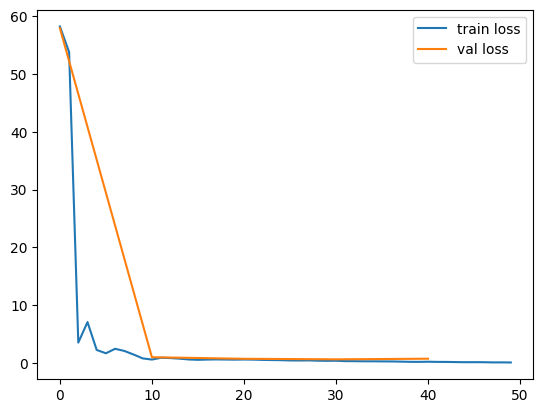

In [92]:
# Ενότητα 9: αποτελέσματα

val_freq = 10

# 100 iteraties trainen
n_epochs = 50
model, train_loss, val_loss = train_medmnist(model, train_dataloader,
                                             val_dataloader, optimizer,
                                             epochs=n_epochs, val_freq=val_freq)

Έχουμε δει παραπάνω τι μπορούν να αναγνωρίσουν συγκεκριμένα kernels μέσα σε μια εικόνα. Αλλά ποια kernels έχει βρει ο αλγόριθμός μας για να ταξινομεί ανάμεσα σε υγιείς και ασθενείς πνεύμονες; Παρακάτω βλέπουμε τα kernels του δεύτερου συνελικτικού επιπέδου. Επειδή το πρώτο επίπεδο έχει ήδη εφαρμόσει 16 συνελίξεις, υπάρχουν 16 διαφορετικά σύνολα kernels στο δεύτερο επίπεδο. Μπορείς να τα δεις όλα προσαρμόζοντας τη μεταβλητή <kbd>input_index</kbd>.

/tmp/ipython-input-969952670.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


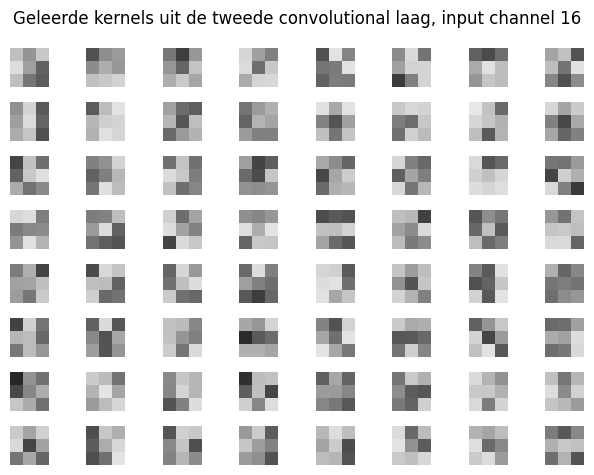

In [93]:
# Ενότητα 10: τα φίλτρα που έμαθε στην πρώτη και δεύτερη στρώση

input_index = 16
fig, axs = plt.subplots(8,8, layout='constrained')
for i in range(64):
    kernel = model.conv2.weight[i,input_index,:,:].detach().cpu().numpy()
    cur_ax = np.unravel_index(i, [8,8])
    s = axs[cur_ax].imshow(kernel, clim=[-0.1,0.1],cmap = 'Greys')
    axs[cur_ax].axis('off')
plt.suptitle(f'Geleerde kernels uit de tweede convolutional laag, input channel {input_index}')
plt.tight_layout()
plt.show()

Και εδώ βλέπουμε επίσης τα kernels από το πρώτο συνελικτικό επίπεδο.

torch.Size([32, 1, 3, 3])


/tmp/ipython-input-2024605393.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


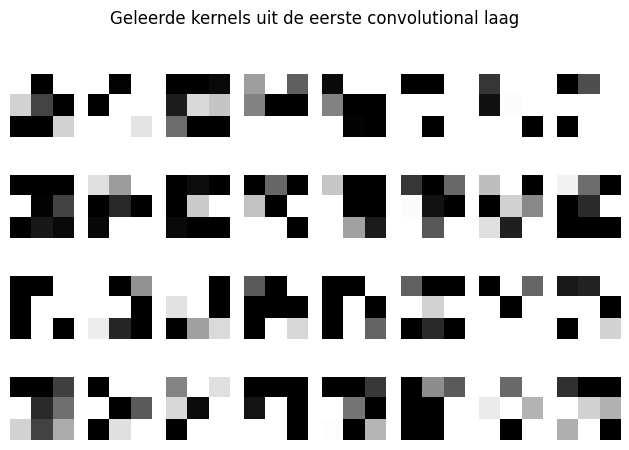

In [94]:
print(np.shape(model.conv1.weight))
fig, axs = plt.subplots(4,8, layout='constrained')
for i in range(32):
    kernel = model.conv1.weight[i,0,:,:].detach().cpu().numpy()
    cur_ax = np.unravel_index(i, [4,8])
    s = axs[cur_ax].imshow(kernel, clim=[-0.1,0.1],cmap = 'Greys')
    axs[cur_ax].axis('off')
plt.suptitle(f'Geleerde kernels uit de eerste convolutional laag')
plt.tight_layout()
plt.show()

## Performance assessment

Τώρα που έχουμε εκπαιδεύσει το μοντέλο, θα εξετάσουμε σε ποιο βαθμό μπορεί να κάνει σωστές προβλέψεις. Πρώτα υπολογίζουμε τη recall και την precision του μοντέλου.

Η **recall** μας δείχνει πόσα από τα θετικά δείγματα χάνονται από το μοντέλο (ψευδώς αρνητικά).

Η **precision** μετρά πόσα από τα δείγματα που ταξινομούνται ως θετικά είναι πράγματι θετικά (ψευδώς θετικά).

Το ποιο μέτρο είναι πιο σημαντικό εξαρτάται από το εκάστοτε πρόβλημα. Για παράδειγμα, στην ανίχνευση μιας εξαιρετικά σπάνιας μορφής καρκίνου, προτιμάμε υψηλή recall και αποδεχόμαστε χαμηλότερη precision. Είναι προτιμότερο να εντοπίζονται τα πραγματικά θετικά και να φιλτράρονται αργότερα τα ψευδώς θετικά σε περαιτέρω εξετάσεις, παρά να χάνονται εντελώς τα θετικά περιστατικά.

Για τον υπολογισμό αυτών των μετρικών χρησιμοποιούμε το test dataset (και όχι το validation dataset).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Πριν υπολογίσουμε αυτές τις μετρικές, θα εξετάσουμε πρώτα μερικές από τις εξόδους του μοντέλου.


In [95]:
#Ενότητα 11: προβλέψεις σε αρχικές ατκίνες

def validation_results_visualize(model, dataset):
    index = np.random.randint(0, len(dataset))
    sample = dataset[index]

    image = sample['img']
    label = sample['label']
    original_img = sample['orig']

    plt.imshow(sample['orig'], cmap='gray')
    plt.yticks([]); plt.xticks([])

    # convert to tensor
    image_t = torch.tensor(image).float().to('cuda') # shape (1,28,28)

    with torch.no_grad():
         output = torch.sigmoid(model(image_t.unsqueeze(0))).item()
         print(index)
         plt.title(
             f"Πραγματική τιμή: {label},"
             f"πιθανότητα απονεύρωσης :{output:.3f},"
             f"πρόβλεψη CNN: {int(output >= 0.5)}")
         plt.show()

4


/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-1017411452.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_t = torch.tensor(image).float().to('cuda') # shape (1,28,28)


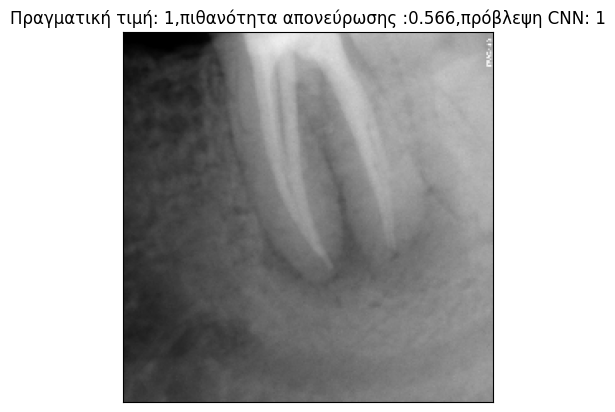

In [96]:
validation_results_visualize(model, test_dataset)

0


/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-1017411452.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_t = torch.tensor(image).float().to('cuda') # shape (1,28,28)


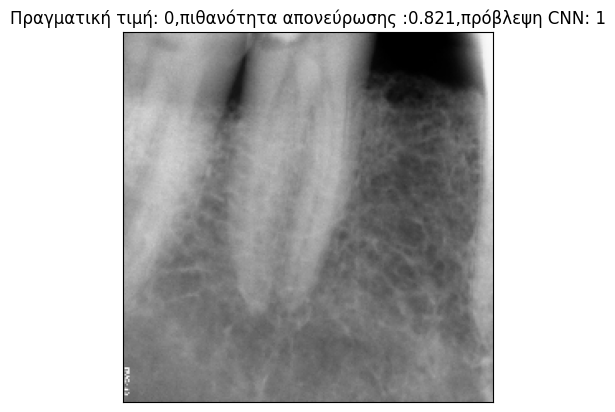

8


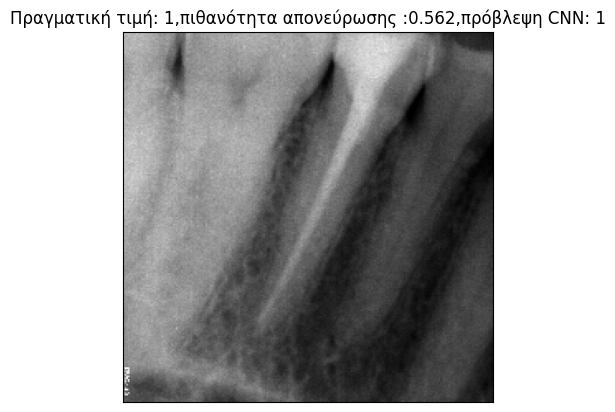

7


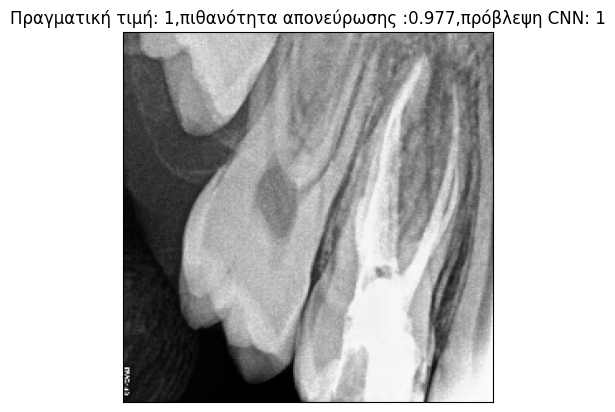

2


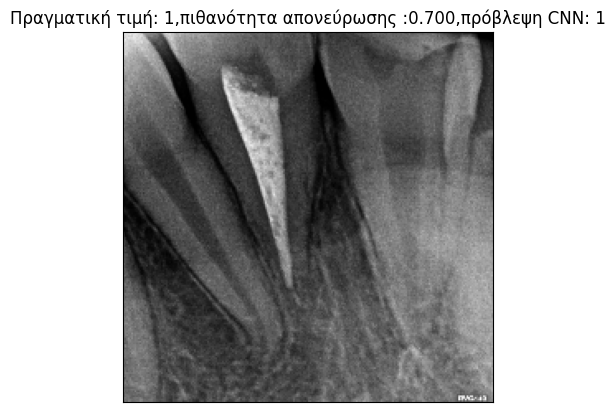

0


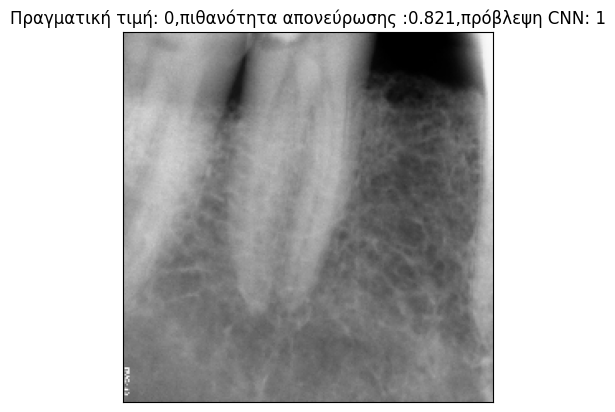

7


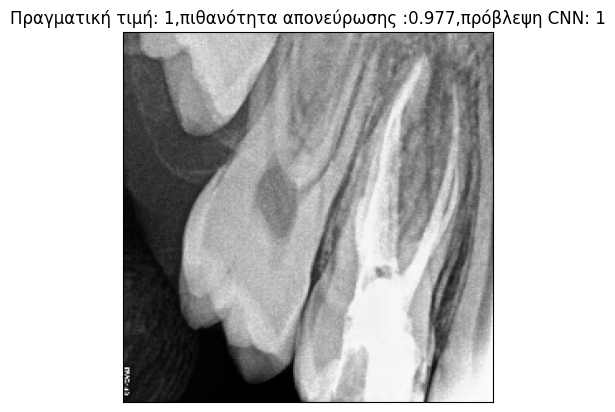

3


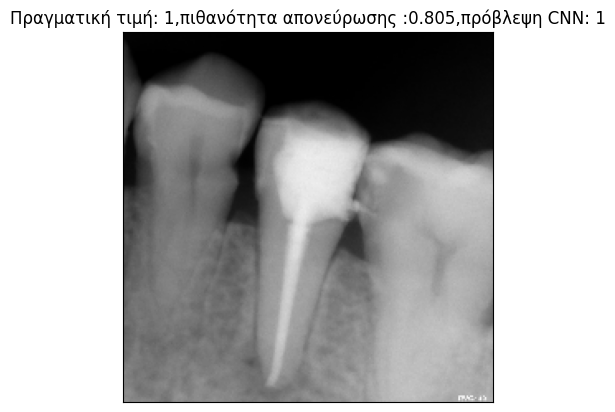

1


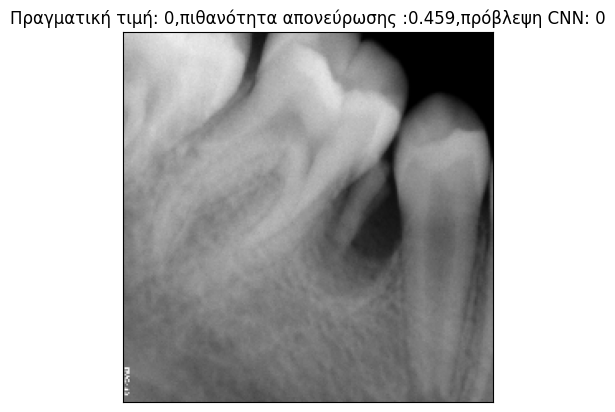

2


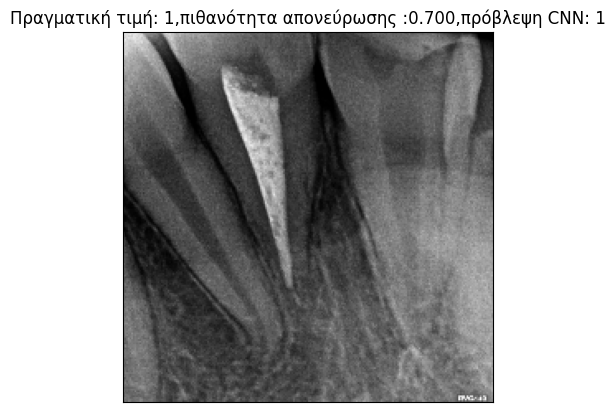

9


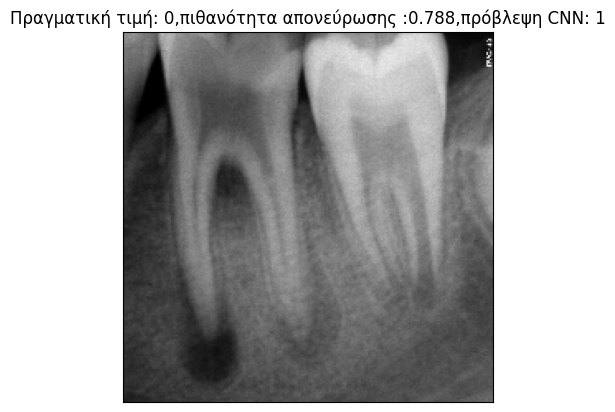

In [97]:
for i in range(10):
    validation_results_visualize(model, test_dataset)

In [98]:
#Ενότητα 12: Ανάλυση της απόδοσης του δικτύου

# we compute precision and recall
def get_precision_recall(model, dataloader):
    model.eval()
    TP, TN, FP, FN = 0, 0, 0, 0

    with torch.no_grad():
         for batch in dataloader:
             images = batch['img'].float().to('cuda') # (B,1,28,28)
             labels = batch['label'].float().to('cuda') # (B,)
             labels = labels.unsqueeze(1) # (B,1)
             outputs = torch.sigmoid(model(images)) # (B,1)
             preds = (outputs >= 0.5).float() # (B,1)
             TP += ((preds == 1) & (labels == 1)).sum().item()
             TN += ((preds == 0) & (labels == 0)).sum().item()
             FP += ((preds == 1) & (labels == 0)).sum().item()
             FN += ((preds == 0) & (labels == 1)).sum().item()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    return precision, recall

In [99]:
test_dataset = TeethMNIST(split="test",transform=data_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)

precision, recall = get_precision_recall(model, test_loader)
print(f'De precision van het getrainde model is {precision:.2f}, de recall van het getrainde model is {recall:.2f}.')

De precision van het getrainde model is 0.62, de recall van het getrainde model is 1.00.


/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


**Ερώτηση**: Τι γνώμη έχεις για την precision και την recall του μοντέλου (λαμβάνοντας επίσης υπόψη πόσο ποσοστό των ασθενών (50%) στα δεδομένα έχει κάνει απονεύρωση);

Παρακάτω μπορείς να δεις ένα λεγόμενο confusion matrix. Πόσες περιπτώσεις πνευμονίας έχουν περάσει απαρατήρητες; Και πόσο συχνά διαγιγνώσκεται ένας ασθενής λανθασμένα με πνευμονία; Τι εικόνα μας δίνει αυτό για το πόσο ισχυρό είναι το μοντέλο; Μπορείς επίσης να βρεις αν το μοντέλο αποδίδει καλά και στο validation dataset; Ο dataloader για το σύνολο επικύρωσης ονομάζεται <kbd>val_dataloader</kbd>.

/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


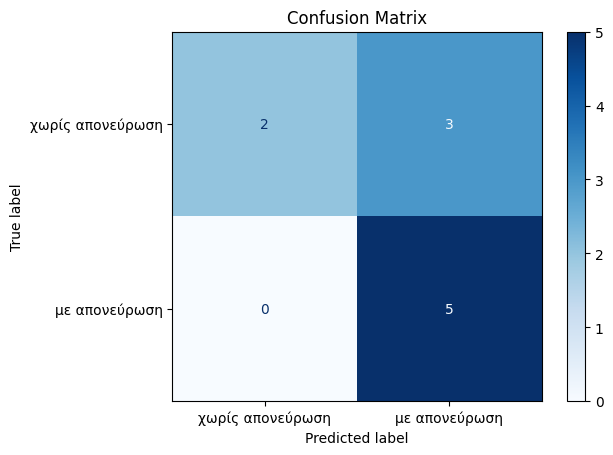

In [100]:
#Ενότητα 13: κατασκευή confusion matrix όπου μπορούμε να δούμε πόσο καλά
# λειτούργησε το δίκτυο

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model,dataloader):
    """
    Plots a confusion matrix using true and predicted labels.

    :param y_true: List or array of true labels.
    :param y_pred: List or array of predicted labels.
    :param labels: List of label names (optional).
    """
    model.eval()
    true_labels = []
    predicted_labels = []


    for data in dataloader:
        images = data['img'].float().to('cuda')
        labels = data['label'].cpu().numpy()
        with torch.no_grad():
            output = torch.sigmoid(model(images)).cpu().numpy().flatten()
        pred_classes = (output >= 0.5).astype(int)
        true_labels.extend(labels)
        predicted_labels.extend(pred_classes)

    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['χωρίς απονεύρωση', 'με απονεύρωση'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

# Τι βλέπει το μοντέλο στην κάθε ακτινογραφία;

Τα νευρωνικά δίκτυα μπορούν να κάνουν πολύ καλές προβλέψεις, αλλά συχνά δεν ξέρουμε πώς έφτασαν σε αυτές.
Το Grad‑CAM μας δείχνει σε ποια σημεία της εικόνας βασίστηκε το μοντέλο για να πάρει την απόφασή του.

Είναι σαν να βάζουμε έναν θερμικό χάρτη πάνω στην ακτινογραφία.

Κόκκινο → το μοντέλο έδωσε μεγάλη σημασία

Κίτρινο/πράσινο → μέτρια σημασία

Μπλε → μικρή ή καθόλου σημασία


In [101]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        # Forward hook → save activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Backward hook → save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass for predicted class
        self.model.zero_grad()
        output.backward()

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted sum of activations
        cam = (weights * self.activations).sum(dim=1).squeeze()

        # Normalize CAM
        cam = cam.cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)

        return cam

In [102]:
def visualize_gradcam(model, dataset, index, device='cuda'):
    sample = dataset[index]

    small_img = sample['img']              # (1,28,28)
    orig_img = sample['orig']              # original image
    label = sample['label']

    # Prepare tensor for model
    input_tensor = torch.tensor(small_img).unsqueeze(0).float().to(device)

    # Build Grad-CAM object
    gradcam = GradCAM(model, model.conv2)

    # Generate CAM
    cam = gradcam.generate(input_tensor)

    # Resize CAM to original image size
    cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    overlay = 0.4 * heatmap + 0.6 * np.stack([orig_img]*3, axis=-1)

    # Plot
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Original image (label={label})")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Grad-CAM heatmap")
    plt.axis('off')

    plt.show()


/tmp/ipython-input-2560102653.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-1274000266.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(small_img).unsqueeze(0).float().to(device)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


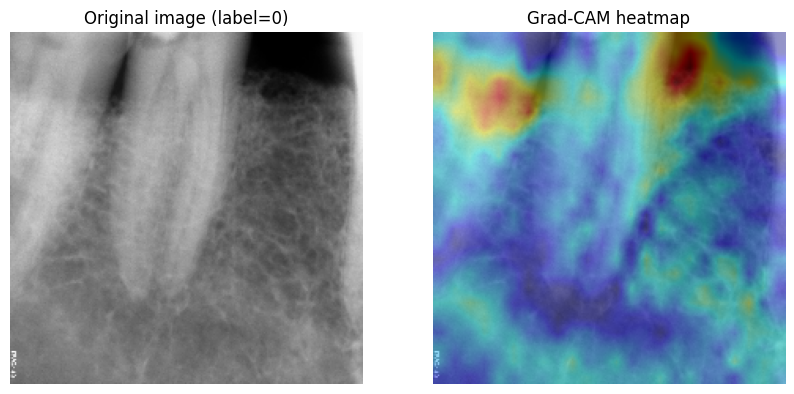

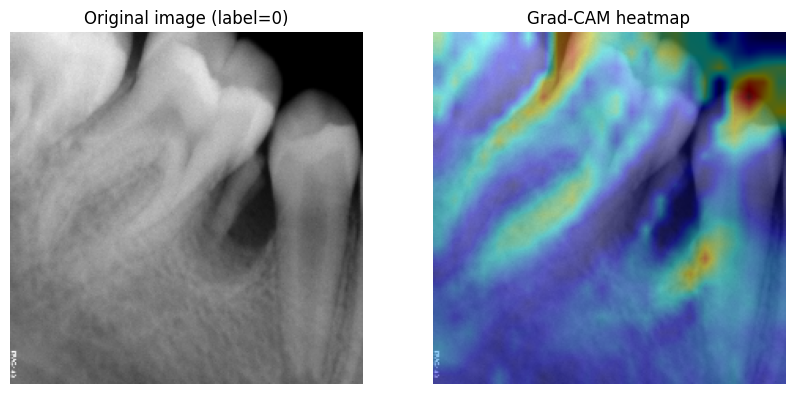

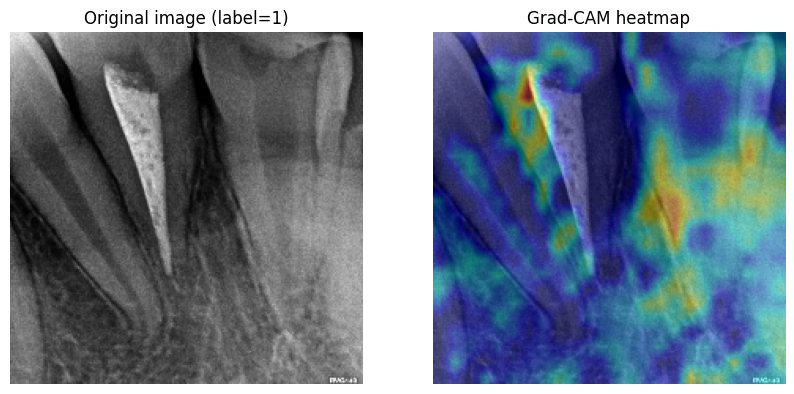

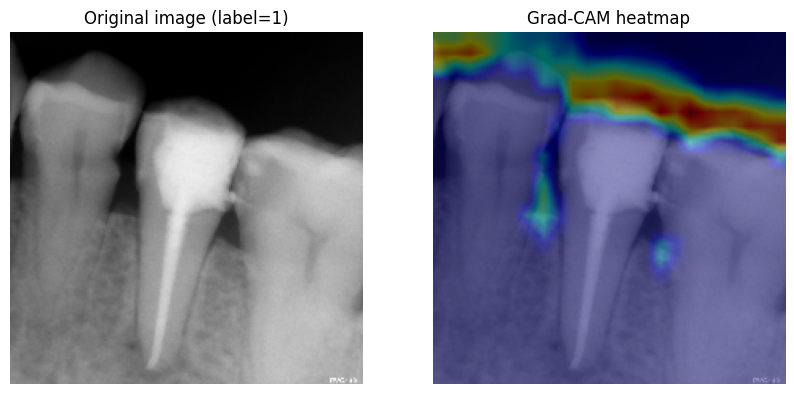

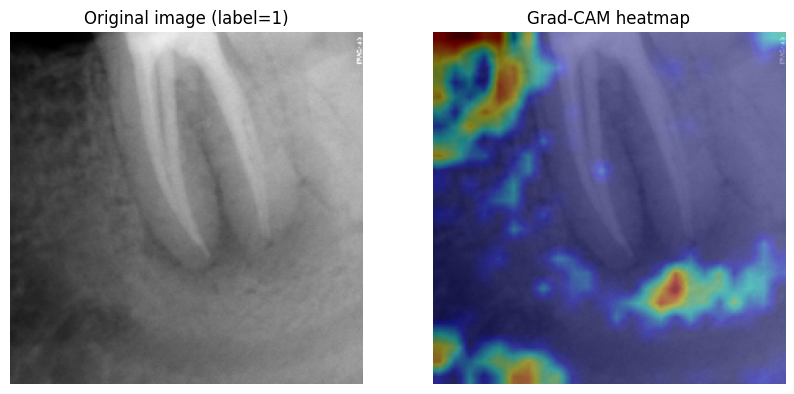

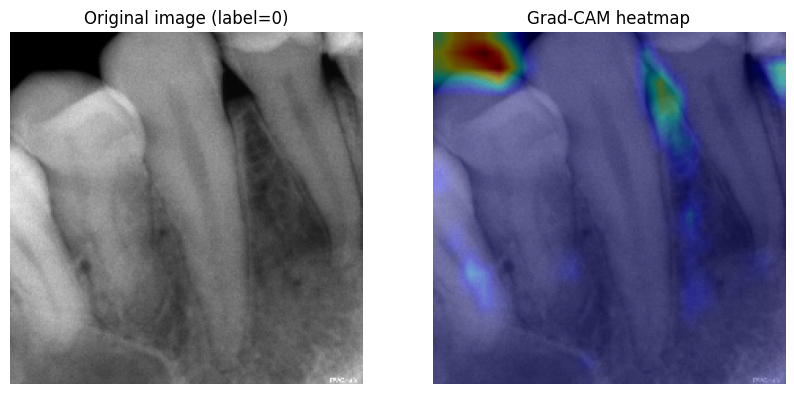

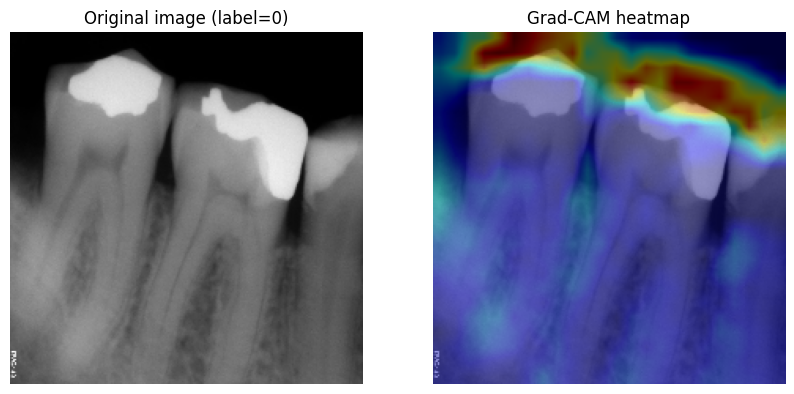

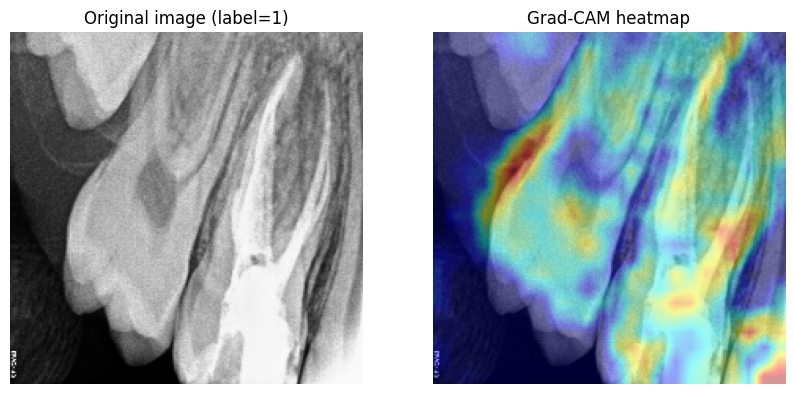

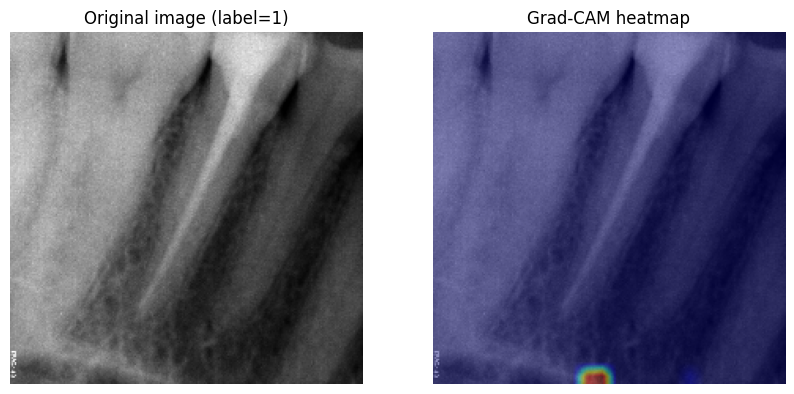

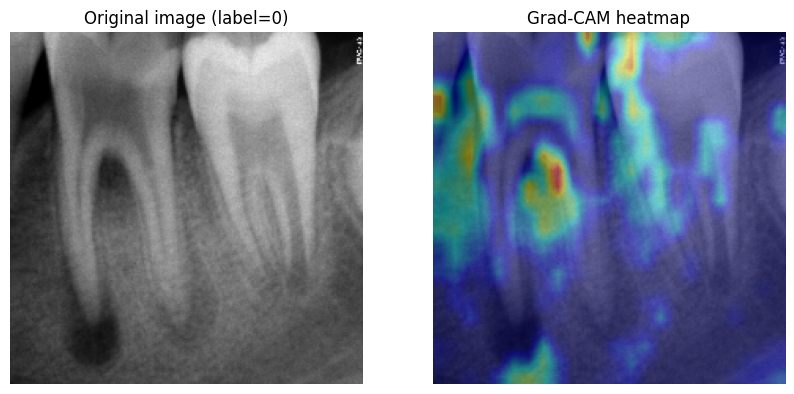

In [104]:
for i in range(10):
    visualize_gradcam(model, test_dataset, i)